In [3]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.abspath(''), '..')))

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from hydracv.midline import find_midline_midpoints, find_midline_midpoints_corrected
from hydracv.fluorescence import trace_fluo
from hydracv.utils import utils

In [2]:
VIDEONAME = "0hr_Control_ngcampmov_30x4fps_50%intensity_TTAP2exp3_a3" # TO MODIFY

## Midline and length

Requirement: 
- contour
- tracked data (results from DeepLabCut)

In [3]:
FILE_CONTOUR = "./data/contour/" + VIDEONAME + ".xml" # TO MODIFY
FILE_MARKER = "./data/marker/0hr_Control_ngcampmov_30x4fps_50%intensity_exp3_a3_enhanced_editDLC_resnet50_TTypectrlFeb26shuffle1_524000.csv" # TO MODIFY

In [4]:
# Original find midline code
midpoints_orig = find_midline_midpoints.find_midline(file_contour=FILE_CONTOUR,
                                                     file_marker=FILE_MARKER,
                                                     nseg=40,
                                                     play=False)

  0%|          | 0/7202 [00:00<?, ?it/s]

Contour loaded, the size is: 7202
Markers loaded, the size is: 7202
Number of missed contours is: 0


100%|██████████| 7202/7202 [00:15<00:00, 457.94it/s]


In [5]:
# Save the original midpoints
FILE_MIDPOINTS = "./data/midpoints/midpoints_" + VIDEONAME + ".csv"
df = pd.DataFrame(midpoints_orig)
df.to_csv(FILE_MIDPOINTS, index=False)

In [ ]:
# Quality-improved version of midpoints
midpoints_corr = find_midline_midpoints_corrected.find_midline(file_contour=FILE_CONTOUR,
                                                                    file_marker=FILE_MARKER,
                                                                    file_midpoints=FILE_MIDPOINTS,
                                                                    nseg=40)

In [ ]:
# Save the corrected midpoints
FILE_MIDPOINTS_CORR = "./data/midpoints/midpoints_corrected_" + VIDEONAME + ".csv"
df = pd.DataFrame(midpoints_corr)
df.to_csv(FILE_MIDPOINTS_CORR, index=False)

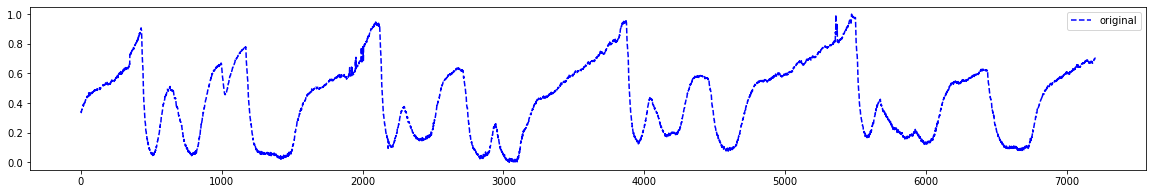

In [7]:
# Plot the length

midpoints_orig_data = find_midline_midpoints_corrected.load_midpoints(FILE_MIDPOINTS)
# midpoints_corr_data = find_midline_midpoints_corrected.load_midpoints(FILE_MIDPOINTS_CORR)

midlens_orig = find_midline_midpoints_corrected.extract_lengths(midpoints_orig_data, normalize=False)
# midlens_corr = find_midline_midpoints_corrected.extract_lengths(midpoints_corr_data)

plt.figure(figsize=(20,3))
# plt.plot(midlens_corr, 'r', label='corrected')
plt.plot(utils.normalize(midlens_orig), 'b--', label='original')
plt.legend()
plt.show()

In [28]:
max(midlens_corr)

1.0

In [9]:
# Save the lengths
FILE_LENGTH = "./data/length/lengths_" + VIDEONAME + ".csv"
df = pd.DataFrame(midlens_orig)
df.to_csv(FILE_LENGTH, index=False)

# Save the lengths
FILE_LENGTH = "./data/length/lengths_corrected_" + VIDEONAME + ".csv"
df = pd.DataFrame(midlens_corr)
df.to_csv(FILE_LENGTH, index=False)

## Fluorescence

Requirement: 
- video

In [6]:
VIDEONAME = 'neural_gcamp_video'
FILE_VIDEO = "./data/videos/NGCaMP/"+VIDEONAME+".avi" # TO MODIFY

In [7]:
# Trace fluorescence
fluo = trace_fluo.trace(FILE_VIDEO, display=False)

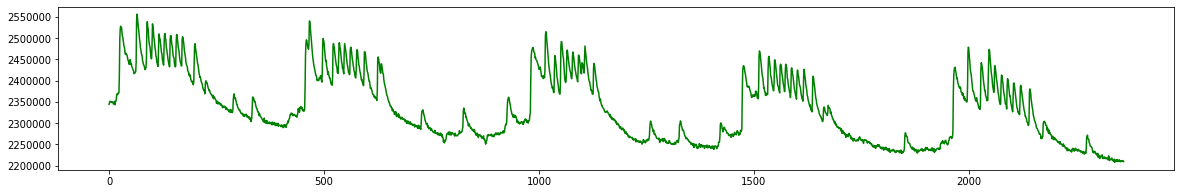

In [8]:
# Plot fluorescence
plt.figure(figsize=(20,3))
plt.plot(fluo, 'g')
plt.show()

In [13]:
# Save the results
FILE_FLUO = "./data/fluorescence/"
df = pd.DataFrame(fluo)
df.to_csv(FILE_FLUO + 'total_fluo_' + VIDEONAME + '.csv', index=False)

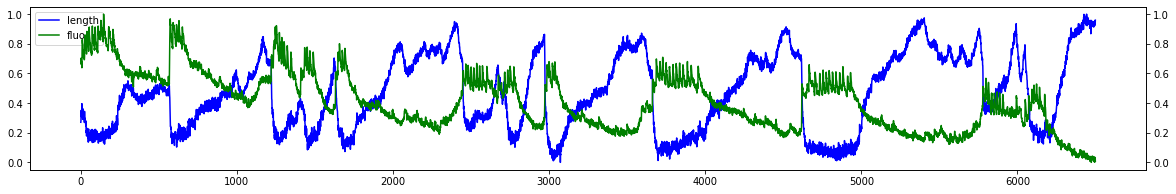

In [19]:
# Plot overlayed length and fluorescence
fluo = utils.normalize(fluo)

FPS = 4
timex = np.arange(0, len(fluo)/FPS, 1/FPS)

fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot(1,1,1)
ax_ = ax.twinx()
lns1 = ax.plot(utils.normalize(midlens_orig[500:7000]), 'b', label='length')
# ax.plot(midlens_corr, 'b', label='corrected')
lns2 = ax_.plot(utils.normalize(fluo[500:7000]), 'g', label='fluo')
# ax.plot(midlens_corr[500:1200], 'r', label='corrected')
# ax_.plot(fluo[500:1200])
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='best')
plt.savefig("./data/overlay_curves/" + VIDEONAME + ".jpg")
plt.show()